In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## OMTF definitions and imports

In [30]:
import glob

import tensorflow as tf
import tensorflow_addons as tfa
#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots
#import tensorflow_docs.modeling

import os
import time
from datetime import datetime
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (10, 7),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

inputDataPrefix = ""

SLURM_CLUSTER_NAME=str(os.getenv("SLURM_CLUSTER_NAME"))
runOnCluster = False
if SLURM_CLUSTER_NAME == "prometheus":
    inputDataPrefix = "/net/people/plgakalinow/plggcmsml/"
    runOnCluster = True
elif SLURM_CLUSTER_NAME == "rysy":   
    inputDataPrefix = "/home/akalinow/"
    runOnCluster = True
else: 
    inputDataPrefix =  "/home/user1/scratch_ssd/akalinow/"
    runOnCluster = False
    
trainDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/"   
testDataDir = inputDataPrefix+"/ProgrammingProjects/MachineLearning/OMTF/data/18_12_2020/" 


nRefLayers = 8
nLayers = 18
nPDFBins = 2**7
minProbability = 0.001
minPlog = np.log(minProbability)
nPdfValBits = 6
refLayers = [0, 7, 2, 6, 16, 4, 10, 11]
#ptBins = np.concatenate((np.arange(0.0, 5, 0.5), np.arange(5, 30, 1), np.arange(30, 40, 5), np.arange(40, 60, 10), np.arange(60, 101, 20), [99999.0]))
ptBins = tf.concat([tf.range(0.0, 5, 0.5), tf.range(5, 30, 1.0, ), tf.range(30, 40, 5.0), tf.range(40, 60, 10.0), tf.range(60, 101, 20.0), [99999.0]], axis=0)

## Start Tensorboard server

In [ ]:
if not runOnCluster:
    %load_ext tensorboard
    %tensorboard --logdir logs/fit --port=8008 --bind_all

## Plotting functions

In [31]:
cumulativePosteriorCut = 0.60
testIndex = 0

def plotPosterior(ptGen, labels, predictions):
    
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    indices = np.logical_and(labels>ptGen-0.1, labels<ptGen+0.1)
        
    predictions = predictions[indices]
    
    ###TEST
    
    #predictions = predictions[:,0:45]
    predictions = predictions[testIndex] 
    predictions = tf.reshape(predictions, (1,-1))
    derivative = np.diff(predictions, append=0)
    #predictions = tf.math.divide_no_nan(derivative, predictions)
    predictions = tf.abs(predictions)
    #sum = tf.reduce_sum(predictions, axis=1, keepdims=True)
    #predictions = 1.0/sum*predictions
    ######
    
    predictions = np.mean(predictions, axis=0)
    maxPosterior = tf.math.reduce_max(predictions)
    scaleFactor = int(0.8/maxPosterior + 0.5)
    axes[0].plot(label2Pt(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
    axes[0].plot(label2Pt(np.arange(predictions.shape[0])), np.cumsum(predictions), linestyle='-.',label="cumulative posterior")
    axes[1].plot(label2Pt(np.arange(predictions.shape[0])), scaleFactor*predictions, label="{}xposterior".format(scaleFactor))
    
    predictions = np.cumsum(predictions, axis=0)>cumulativePosteriorCut
    predictions = np.argmax(predictions, axis=0)
    ptRec = label2Pt(predictions)
    print("Pt gen = {}, Pt rec {} cumulative posterior: {}".format(ptGen, cumulativePosteriorCut, ptRec))
    axes[0].axvline(ptGen, linestyle='-', color="olivedrab", label=r'$p_{T}^{GEN} \pm 1 [GeV/c]$')
    axes[0].axvline(ptRec, linestyle='--', color="r", label=r'$p_{T}^{REC} @ cum~post.=$'+str(cumulativePosteriorCut))
    
    axes[0].set_xlabel(r'$p_{T} [GeV/c]$')
    axes[0].set_ylabel('Value')
    axes[0].set_xlim([0, 2*ptGen])
    axes[0].set_ylim([1E-3,1.05])
    
    axes[0].legend(bbox_to_anchor=(2.5,1), loc='upper left')
    axes[1].set_xlabel(r'$p_{T} [GeV/c]$')
    axes[1].set_ylabel('Value')
    axes[1].set_xlim([0,201])
    axes[1].set_ylim([1E-3,1.05])
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.3)
    plt.savefig("fig_png/Posterior_ptGen_{}.png".format(ptGen), bbox_inches="tight")
    
    
def plotTurnOn(dataset, ptCut):
    ptMax = ptCut+50
    #ptMax = 10 #TEST
    nPtBins = int(ptMax*2.0)
    ptHistoBins = range(0,nPtBins+1)

    num = np.zeros(nPtBins)
    numML = np.zeros(nPtBins)
    denom = np.zeros(nPtBins)
    
    count =0
    for aBatch in dataset.as_numpy_iterator():
        labels = aBatch[1][0]
        omtfPredictions = aBatch[2]
        count += labels.shape[0]
        predictions = model.predict(aBatch[0], use_multiprocessing=True)
        predictions = predictions[0]
        predictions = predictions[:,0:45] #TEST
        predictions = np.cumsum(predictions, axis=1)>cumulativePosteriorCut
        predictions = np.argmax(predictions, axis=1)   
        predictions = label2Pt(predictions)
        
        tmp,_ = np.histogram(labels, bins=ptHistoBins)    
        denom +=tmp
        tmp,_ = np.histogram(labels[omtfPredictions>=ptCut], bins=ptHistoBins)
        num += tmp
        tmp,_ = np.histogram(labels[predictions>=ptCut], bins=ptHistoBins)
        numML += tmp
        
    fig, axes = plt.subplots(1, 3)
    ratio = np.divide(num, denom, out=np.zeros_like(denom), where=denom>0)
    ratioML = np.divide(numML, denom, out=np.zeros_like(denom), where=denom>0)
    axes[0].plot(ptHistoBins[:-1],num, label="OMTF")
    axes[0].plot(ptHistoBins[:-1],numML, label="ML")
    axes[0].set_xlim([0,2.0*ptCut])
    #axes[0].set_ylim([0,1.0])
    axes[0].set_xlabel(r'$p_{T}^{GEN}$')
    axes[0].set_ylabel('Events passing pT cut')
    axes[0].legend(loc='upper left')
    
    axes[1].plot(ptHistoBins[:-1],ratio, label="OMTF")
    axes[1].plot(ptHistoBins[:-1],ratioML, label="ML")
    axes[1].grid()
    axes[1].set_yscale("log")
    axes[1].set_xlim([0,ptMax])
    axes[1].set_ylim([1E-3,1.05])
    axes[1].set_xlabel(r'$p_{T}^{GEN}$')
    axes[1].set_ylabel('Efficiency')

    axes[2].plot(ptHistoBins[:-1],ratio, label="OMTF")
    axes[2].plot(ptHistoBins[:-1],ratioML, label="ML")
    axes[2].grid()
    axes[2].axhline(y=0.5)
    axes[2].axhline(y=0.85)
    axes[2].axvline(x=ptCut)
    axes[2].set_xlim([0,ptMax])
    axes[2].set_ylim([0.0,1.05])
    axes[2].set_xlabel(r'$p_{T}^{GEN}$')
    axes[2].set_ylabel('Efficiency')
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.5)
    plt.savefig("fig_png/TurnOn_ptCut_{}.png".format(ptCut), bbox_inches="tight")
    
    
def plotPull(labels, predictions, omtfPredictions):
    
    minX = -1
    maxX = 2
    nBins = 50
    predictions = np.cumsum(predictions, axis=1)>cumulativePosteriorCut
    predictions = np.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)   
    error = (predictions - labels)/labels
    omtfError = (omtfPredictions - labels)/labels    
    fig, axes = plt.subplots(1, 2, figsize = (12, 5))  
    axes[0].hist(error, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[0].hist(omtfError, range=(minX, maxX), bins = nBins, color="tomato", label="OMTF")
    axes[0].set_xlabel("(Model - True)/True")
    axes[0].legend(loc='upper right')
    axes[0].set_xlim([minX, maxX])
    #axes[0].set_ylim([-2,2])
    
    axes[1].hist(omtfError, range=(minX, maxX), bins = nBins, color="tomato", label="OMTF")
    axes[1].hist(error, range=(minX, maxX), bins = nBins, color="deepskyblue", label = "NN")
    axes[1].set_xlabel("(Model - True)/True")
    axes[1].legend(loc='upper right')
    axes[1].set_xlim([minX, maxX])
    plt.savefig("fig_png/Pull.png", bbox_inches="tight")
 
def plotCM(labels, predictions, omtfPredictions):
    
    fig, axes = plt.subplots(2, 2, figsize = (10, 10))  
    
    ptMax =  ptBins.shape[0]  
    vmax = 1.0
    ptPredictions = np.cumsum(predictions[0], axis=1)>cumulativePosteriorCut
    ptPredictions = np.argmax(ptPredictions, axis=1)   
    cm = tf.math.confusion_matrix(pT2Label(labels[0]), ptPredictions)
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    #vmax = tf.math.reduce_max(cm)
    
    myPalette = sns.color_palette("YlGnBu", n_colors=20)
    myPalette[0] = (1,1,1)
    
    vmax = 0.1 #TEST
    sns.heatmap(cm, ax = axes[0,0], vmax = vmax, annot=False, xticklabels=4, yticklabels=4, cmap=myPalette)
    axes[0,0].set_ylabel(r'$p_{T}^{NN} \rm{[bin ~number]}$');
    axes[0,0].set_xlabel(r'$p_{T}^{GEN} \rm{[bin ~number]}$');
    axes[0,0].grid()
    axes[0,0].set_ylim([0,ptMax])
    axes[0,0].set_xlim([0,ptMax])
    axes[0,0].set_aspect(aspect='equal')
    axes[0,0].set_title("NN")
    
    cm = tf.math.confusion_matrix(pT2Label(labels[0]), pT2Label(omtfPredictions[0]))
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    #vmax = tf.math.reduce_max(cm)
    sns.heatmap(cm, ax = axes[0,1], vmax = vmax, annot=False, xticklabels=4, yticklabels=4, cmap=myPalette)
    axes[0,1].grid()
    axes[0,1].set_title("OMTF")
    axes[0,1].set_xlim([0,ptMax])
    axes[0,1].set_ylim([0,ptMax])
    axes[0,1].set_aspect(aspect='equal')
    axes[0,1].set_ylabel(r'$p_{T}^{OMTF} \rm{[bin ~number]}$')
    axes[0,1].set_xlabel(r'$p_{T}^{GEN} \rm{[bin ~number]}$') 
        
    chPredictions =tf.map_fn(lambda x: x>0.5, predictions[1], dtype=tf.bool)
    chPredictions = tf.reshape(chPredictions, (-1,1))
    chLabels =tf.map_fn(lambda x: x>0.5, labels[1], dtype=tf.bool)
    #chLabels = tf.reshape(chLabels, (-1,1))
    
    vmax = 1.0
    vmin = 0.0
    cm = tf.math.confusion_matrix(chLabels, chPredictions)
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    sns.heatmap(cm, ax = axes[1,0], vmax = vmax, annot=True, cmap=myPalette)
    axes[1,0].set_title("NN")
    axes[1,0].set_aspect(aspect='equal')
    axes[1,0].set_ylabel(r'$q^{NN}$')
    axes[1,0].set_xlabel(r'$q^{GEN}$') 
    
    chPredictions =tf.map_fn(lambda x: x>0.5, omtfPredictions[1], dtype=tf.bool)  
    chPredictions = tf.reshape(chPredictions, (-1,1))
    cm = tf.math.confusion_matrix(chLabels, chPredictions)
    cm = tf.cast(cm, dtype=tf.float32)
    cm = tf.math.divide_no_nan(cm, tf.math.reduce_sum(cm, axis=1)[:, np.newaxis])
    cm = tf.transpose(cm)
    sns.heatmap(cm, ax = axes[1,1], vmax = vmax, annot=True, cmap=myPalette, linewidths=0.01)
    axes[1,1].set_title("OMTF")
    axes[1,1].set_aspect(aspect='equal')
    axes[1,1].set_ylabel(r'$q^{NN}$')
    axes[1,1].set_xlabel(r'$q^{GEN}$') 
    
    plt.subplots_adjust(bottom=0.15, left=0.05, right=0.95, wspace=0.25, hspace=0.35)
    plt.savefig("fig_png/CM.png", bbox_inches="tight")

## Data manipulation functions

In [53]:
columns = np.array(['muonPt', 'muonEta', 'muonPhi', 'muonCharge', 'omtfPt', 'omtfEta',
       'omtfPhi', 'omtfCharge', 'omtfScore', 'omtfQuality', 'omtfRefLayer',
       'omtfProcessor', 'omtfFiredLayers', 'phiDist_0', 'phiDist_1',
       'phiDist_2', 'phiDist_3', 'phiDist_4', 'phiDist_5', 'phiDist_6',
       'phiDist_7', 'phiDist_8', 'phiDist_9', 'phiDist_10', 'phiDist_11',
       'phiDist_12', 'phiDist_13', 'phiDist_14', 'phiDist_15', 'phiDist_16',
       'phiDist_17'])

def getFeaturesMask():
    featuresMask = np.full_like(columns, False, dtype=np.bool)
    for iLayer in range(0, 18):
        featureLabel = "phiDist_{}".format(iLayer)
        featuresMask += (columns==featureLabel)
    #featuresMask += columns=="omtfFiredLayers"
    #featuresMask += columns=="omtfRefLayer"
    #featuresMask += columns=="omtfPt"
    #featuresMask = columns=="omtfQuality"
    return featuresMask

def getFeature(name, dataRow):
    columnIndex = np.where(columns == name)[0][0]  
    return dataRow[:,columnIndex]

def parse_tensor(tensor):
    return tf.io.parse_tensor(tensor, out_type=tf.float32)

def pT2Label(tensor):
    tensor = tf.searchsorted(ptBins, tensor, side='left')
    return tensor
    
def label2Pt(tensor):  
    return tf.where(ptBins.numpy()[tensor]<9999, ptBins.numpy()[tensor], [200])

def modifyFeatures(dataRow, batchSize, isTrain=False):
    columnsMask = getFeaturesMask()
    features = tf.boolean_mask(dataRow, columnsMask, axis=1)
    dummyValue = 128 #TEST
    features = tf.where(features<9999, features, dummyValue) 
    features.set_shape([batchSize,np.count_nonzero(columnsMask)])
    
    columnIndex = np.where(columns == "muonCharge")[0][0]  
    chargeLabels = (dataRow[:,columnIndex]+1)/2 
    chargeLabels.set_shape([batchSize,])
    
    columnIndex = np.where(columns == "muonPt")[0][0]
    ptLabels = dataRow[:,columnIndex]
    ptLabels.set_shape([batchSize,])
    trainWeight = 1.0#tf.math.exp(-ptLabels/10.0)
    
    if isTrain:
        ptLabels = pT2Label(ptLabels)
        return (features, (ptLabels, chargeLabels), trainWeight)
    else:
        columnIndex = np.where(columns == "omtfPt")[0][0]  
        omtfPt = dataRow[:,columnIndex]
        columnIndex = np.where(columns == "omtfQuality")[0][0]  
        omtfQuality = dataRow[:,columnIndex]
        omtfPt = tf.where(omtfQuality>=12, omtfPt, 0) 
        omtfPt.set_shape([batchSize,])
        
        columnIndex = np.where(columns == "omtfCharge")[0][0]  
        omtfCharge = dataRow[:,columnIndex]
        omtfCharge.set_shape([batchSize,])
        return (features, (ptLabels, chargeLabels), omtfPt, omtfCharge)
    return dataRow
    
def loadDataset(fileNames, isTrain, nEpochs=1, batchSize=1):   
    raw_dataset = tf.data.TFRecordDataset(fileNames, compression_type="GZIP") #GZIP
    dataset = raw_dataset.map(parse_tensor,num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batchSize, drop_remainder=True)
    #Split data into [features, labels] and modify features
    dataset = dataset.map(lambda x: modifyFeatures(x, batchSize, isTrain))
    return dataset

def benchmark(dataset, num_epochs=2):
    start_time = time.perf_counter()
    for epoch_num in range(num_epochs):
        for sample in dataset:
            # Performing a training step
            time.sleep(1E-10)
    tf.print("Execution time:", time.perf_counter() - start_time)

## Define models

In [33]:
def pull_mean_metric(y_true, y_pred):    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels   
    mean = tf.math.reduce_mean(pull, axis=0)
    return mean 
    
def pull_variance_metric(y_true, y_pred):
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)   
    predictions = label2Pt(predictions)
    predictions = tf.reshape(predictions, (-1,1))
    labels = label2Pt(tf.cast(y_true, tf.int32))
    pull = (labels - predictions)/labels  
    variance = tf.math.reduce_variance(pull, axis=0) 
    return tf.sqrt(variance) 

def my_loss_fn(y_true, y_pred):
    
    predictions = tf.math.cumsum(y_pred, axis=1)>cumulativePosteriorCut
    predictions = tf.math.argmax(predictions, axis=1)
    predictions = tf.reshape(predictions, (-1,1))
    #lowPtLoss = (labels<(10))*(predictions>(15))
    labels = y_true

    lowPtLoss = tf.math.logical_and(tf.math.less(labels, 10), tf.math.greater(predictions, 10))
    lowPtLoss = (predictions-labels)*lowPtLoss
    lowPtLoss = tf.cast(lowPtLoss, float32)
    
    return tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)(y_true, y_pred) + lowPtLoss


custom_objects={'pull_mean_metric': pull_mean_metric,
                'pull_variance_metric':pull_variance_metric,
                'my_loss_fn':my_loss_fn
               }
def getModel():
    
  nPtBins =  ptBins.shape[0]
  nInputs = np.sum(getFeaturesMask())
  inputs = tf.keras.Input(shape=(nInputs,), name="deltaPhi")
  activation = tf.keras.layers.Activation(tfa.activations.mish)
    
  ptLayer = inputs
  for iLayer in range(0,5):
            ptLayer = tf.keras.layers.Dense(256, activation=activation, name="Pt_layer_{}".format(iLayer))(ptLayer)
    
  chargeLayer= inputs 
  for iLayer in range(0,1): 
       chargeLayer = tf.keras.layers.Dense(32, activation=activation, name="Charge_layer_{}".format(iLayer))(chargeLayer)
    
  ptOutput = tf.keras.layers.Dense(nPtBins, activation=tf.nn.softmax,bias_initializer='zeros',name = "pt")(ptLayer) 
  chargeOutput = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid,name = "charge")(chargeLayer)
        
  model = tf.keras.Model(inputs=inputs, outputs=[ptOutput, chargeOutput], name="NN_OMTF")

  initial_learning_rate = 0.005
  lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                loss={"pt":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      #"pt":tfa.losses.SigmoidFocalCrossEntropy(from_logits=False),
                      "charge":tf.keras.losses.BinaryCrossentropy(from_logits=False)},                    
                metrics=['accuracy'])
  tf.keras.utils.plot_model(model, 'fig_png/ML_model.png', show_shapes=True)
  return model

## Load train and test datasets

In [ ]:
trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')
train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=2)

#dataset = train_dataset.take(10000)
#benchmark(dataset)
#benchmark(dataset.prefetch(tf.data.experimental.AUTOTUNE))

mask = tf.constant([0,1,2,3,10,11,12,13], dtype=tf.int32)
print(mask)

for element in train_dataset.take(10): 
  print(element[0])
  y = tf.gather(params=element[0], indices=mask, axis=1)
  print(y)  
  break

## Train model

In [56]:
current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training start. Current Time =", current_time)

trainFileNames = glob.glob(trainDataDir+'OMTFHits_pats0x0003_oldSample_files_*_chunk_0.tfrecord.gzip')
validationFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')

train_dataset = loadDataset(trainFileNames, isTrain=True, nEpochs=1, batchSize=2*4096)
validation_dataset = loadDataset(validationFileNames, isTrain=True, nEpochs=1, batchSize=1024)

model = getModel()

#nEpochsSaved = 5
#checkpoint_path = "training/model_full_{epoch:04d}"
#model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
#tqdm_callback = tfa.callbacks.TQDMProgressBar()

nEpochs = 10
history = model.fit(train_dataset, epochs=nEpochs,
                    use_multiprocessing=True,
                    verbose=1,
                    shuffle=False,
                    validation_data=validation_dataset.take(10),
                    callbacks=[tensorboard_callback]
                   )

# Save the whole model
path = "training/model_full_{epoch:04d}"
model.save(path.format(epoch=nEpochs), save_format='tf')
#Save model weights
path = "training/model_weights_{epoch:04d}.ckpt"
model.save_weights(path.format(epoch=nEpochs))

current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")
print("Training end. Current Time =", current_time)

Training start. Current Time = Dec 21 2020 08:18:20
Epoch 1/10
      2/Unknown - 0s 245ms/step - loss: 33.7009 - pt_loss: 20.2126 - charge_loss: 13.4883 - pt_accuracy: 0.0187 - charge_accuracy: 0.5892WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0500s vs `on_train_batch_end` time: 0.4368s). Check your callbacks.
5085/5085 [==============================] - 217s 43ms/step - loss: 1.9429 - pt_loss: 1.7662 - charge_loss: 0.1766 - pt_accuracy: 0.3581 - charge_accuracy: 0.9339 - val_loss: 2.4692 - val_pt_loss: 1.9861 - val_charge_loss: 0.4830 - val_pt_accuracy: 0.3812 - val_charge_accuracy: 0.9132
Epoch 2/10
5085/5085 [==============================] - 214s 42ms/step - loss: 1.7402 - pt_loss: 1.6439 - charge_loss: 0.0963 - pt_accuracy: 0.3817 - charge_accuracy: 0.9595 - val_loss: 2.4820 - val_pt_loss: 2.0398 - val_charge_loss: 0.4422 - val_pt_accuracy: 0.3775 - val_charge_accuracy: 0.9339
Epoch 3/10
5085/5085 [====================

## Model evaluation

The plots show the "posterior" probability that a given muons has $p_{T}$ in given bin. The correct behaviour is a peak round the true value, marked by a gren line.
Unfortunetly a small fraction of muons with very low true $p_{T}$, around a few GeV/c receive a vey large $p_{T}$ assigned by the NN: this is a big bump around 100 GeV/c.
This can be seen on the second plot: a efficency plot, where Y axis show fraction of muons with true $p_{T}$ marked by the X value, that get a NN or OMTF (human designed algorithm) greater or equal to 20 GeV/c. A small peak arount 3 GeV/c is visible. **Although this is small, it has very bad consequences, and has to be removed.**

Current Time = Dec 21 2020 09:00:18
Pt gen = 3, Pt rec 0.6 cumulative posterior: [4.]


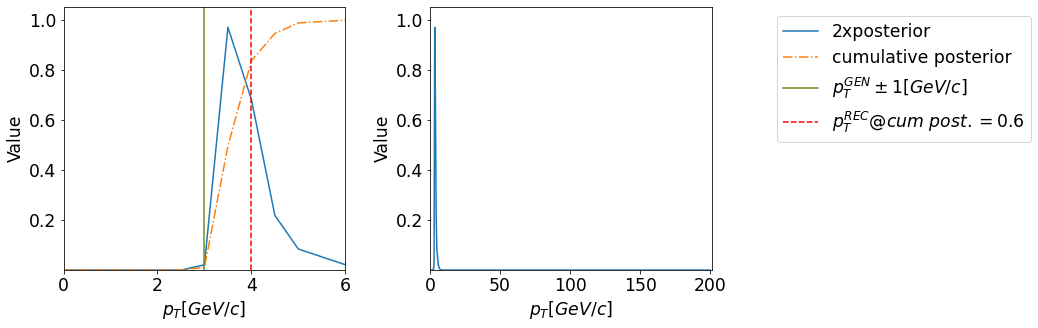

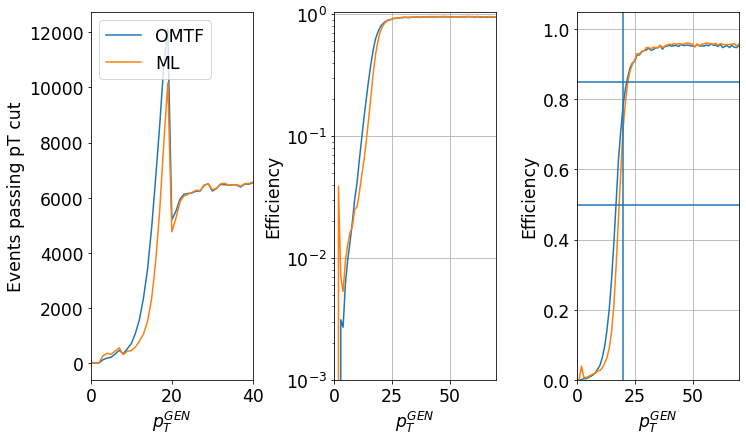

In [58]:
testIndex = 11

if not runOnCluster:
    
    current_time = datetime.now().strftime("%b %d %Y %H:%M:%S")   
    print("Current Time =", current_time)
    
    nEpochsSaved = 2
    checkpoint_path = "training/model_full_{epoch:04d}"
    model = tf.keras.models.load_model(checkpoint_path.format(epoch=nEpochsSaved), custom_objects=custom_objects)

    testFileNames = glob.glob(testDataDir+'OMTFHits_pats0x0003_newerSample_files_1_100_chunk_0.tfrecord.gzip')    
    test_dataset = loadDataset(testFileNames, isTrain=False, nEpochs=1, batchSize=32*1024)
    
    for aBatch in test_dataset.as_numpy_iterator():
            labels = aBatch[1]
            omtfPredictions = aBatch[2:4] 
            predictions = model.predict(aBatch[0], use_multiprocessing=True)         
            plotPosterior(3, labels=labels[0], predictions=predictions[0])
            #plotPosterior(10, labels=labels[0], predictions=predictions[0])
            #plotPosterior(20, labels=labels[0], predictions=predictions[0])
            #plotPosterior(21, labels=labels[0], predictions=predictions[0])
            #plotPosterior(22, labels=labels[0], predictions=predictions[0])
            #plotPosterior(30, labels=labels[0], predictions=predictions[0])
            #plotPosterior(40, labels=labels[0], predictions=predictions[0])
            #plotPosterior(50, labels=labels[0], predictions=predictions[0])
            #plotPull(labels=labels[0], predictions=predictions[0], omtfPredictions=omtfPredictions[0])
            #plotCM(labels=labels, predictions=predictions, omtfPredictions=omtfPredictions)
            break
       
    
    #plotTurnOn(dataset = test_dataset, ptCut=5) 
    #plotTurnOn(dataset = test_dataset, ptCut=10)
    plotTurnOn(dataset = test_dataset, ptCut=20)
    #plotTurnOn(dataset = test_dataset, ptCut=22)
    #plotTurnOn(dataset = test_dataset, ptCut=25)
    #plotTurnOn(dataset = test_dataset, ptCut=50)